Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.1 RBM

Do obsługi zbiorów danych stworzyłem plik pomocniczy `lab7_utils.py`, którego to wykorzystuję w każdym poleceniu aby załadować i odpowiednio przygotować potrzebne dla modelu dane.

In [2]:
import importlib
import lab7_utils as utils
importlib.reload(utils)

seed = 42

W pierszej kolejności uruchomiłem funkcję `find_and_viz_best_estimator()` dla każdego zbioru danych przekazując następujące parametry dla wyszukiwania siatkowego:

```
param_grid = {
    "rbm__n_components": [128, 256, 384],
    "rbm__learning_rate": [0.01, 0.05, 0.1],
    "rbm__batch_size": [10, 20],
    "log_reg__C": [0.1, 0.5, 1.0],
    "log_reg__solver": ["lbfgs", "sag"],
}
```

Po czym zauważyłem, że dla każdego zbioru danych najlepsze wyniki otrzymujemy zawsze dla największego rozmiaru warstwy ukrytej (parametr: `n_components`). Postanowiłem więc uruchomić wyszukiwanie siatkowe ponownie dla każdego ze zbiorów danych, z tym że warstwy ukryte będą wyliczone dla rozmiarów `[16, 32, 64, 128, 256, 384, 512, 640, 784]`, natomiast pozostałe parametry przyjmują najlepsze wartości z pierwszego wyszukiwania siatkowego. W ten sposób chcę przedstawić przyrost `accuracy` wraz ze wzrostem rozmiaru warstwy ukrytej.  
(Wyniki z pierwszego wyszukiwania siatkowego dołączone są w formie tekstowej do każdego przebadanego zbioru danych)

Poniżej znajduje się funkcja przeprowadzająca wyszukiwanie siatkowe oraz wizualizująca zmieniające się `accuracy` wraz ze zmianą rozmiaru warstwy ukrytej:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

def viz_estimators(grid_search_res):
    accuracies = np.array(grid_search_res.cv_results_['mean_test_score'])
    params = np.array(list(map(lambda t: t['rbm__n_components'], grid_search_res.cv_results_['params'])))

    plt.figure(figsize=(8, 5))
    plt.plot(params, accuracies)
    plt.title("Accuracy - Hidden Layer Dimension")
    plt.xlabel("Hidden Layer Dimension")
    plt.ylabel("Accuracy")
    plt.show()

    for i in range(len(params)):
        print(f"[{params[i]}: {accuracies[i]:.4f}]", end=" ")
    print()

def find_and_viz_best_estimator(X_train, y_train, max_iter, param_grid):
    rbm = BernoulliRBM(random_state=seed)
    log_reg = LogisticRegression(max_iter=max_iter)

    pipeline = Pipeline([
        ('rbm', rbm),
        ('log_reg', log_reg)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=7, n_jobs=-1, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)

    viz_estimators(grid_search)

    print(f"Best parameters: {grid_search.best_params_}")

    return grid_search.best_estimator_

Poniżej funkcja listująca wynik klasyfikacji użwywając `classification_report` dla baseline-u, oraz RBM o najlepszych parametrach z wyszukiwania siatkowego:

In [5]:
from sklearn.metrics import classification_report

def compare_baseline_with_best_estimator(baseline_model, best_estimator_model, X_train, y_train, X_test, y_test):
    baseline_model.fit(X_train, y_train)
    y_pred = baseline_model.predict(X_test)
    print(f"--- Baseline: ---\n\n{classification_report(y_test, y_pred)}")

    y_pred = best_estimator_model.predict(X_test)
    print(f"--- Best Estimator: ---\n\n{classification_report(y_test, y_pred)}")

Ostatnia funkcja pomocnicza, która pozwoli nam zwizualizować wagi przypisane każdemu neuronowi warstwy widocznej w połączeniu z wybranym neuronem warstwy ukrytej. Ponieważ najprawdopodobniej wynik z wyszukiwania siatkowego będzie posiadał bardzo dużo neuronów warstwy ukrytej, dla wizualizacji trenuję mniejszy RBM, który w czytelniejszy sposób pokaże rozlokowanie wag, a co za tym idzie, ekstrakcję cech.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def viz_weights(rbm, X_train, y_train):
    rbm.fit(X_train, y_train)

    weights = rbm.components_

    n_components = weights.shape[0]
    image_shape = (28, 28)

    _, axes = plt.subplots(int(np.sqrt(n_components)), int(np.sqrt(n_components)), figsize=(16, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(weights[i].reshape(image_shape), cmap='gray')
        ax.axis('off')
    plt.show()

### MNIST

Wynik dla następujących parametrów wyszukiwania siatkowego:

```
    param_grid = {
        "rbm__n_components": [128, 256, 384],
        "rbm__learning_rate": [0.01, 0.05, 0.1],
        "rbm__batch_size": [10, 20],
        "log_reg__C": [0.1, 0.5, 1.0],
        "log_reg__solver": ["lbfgs", "sag"],
    }

Best parameters: {'log_reg__C': 0.5, 'log_reg__solver': 'sag', 'rbm__batch_size': 20, 'rbm__learning_rate': 0.05, 'rbm__n_components': 384}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.94      0.96      0.95       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000
```

a następnie dla wielkości warstwy ukrytej o następujących wartościach: 16, 32, 64, 128, 256, 384, 512, 640, 784

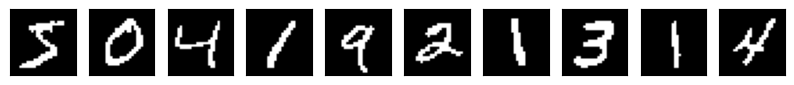



----- Odnajdowanie najlepszego RBM do klasyfikacji -----


Fitting 7 folds for each of 9 candidates, totalling 63 fits


/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


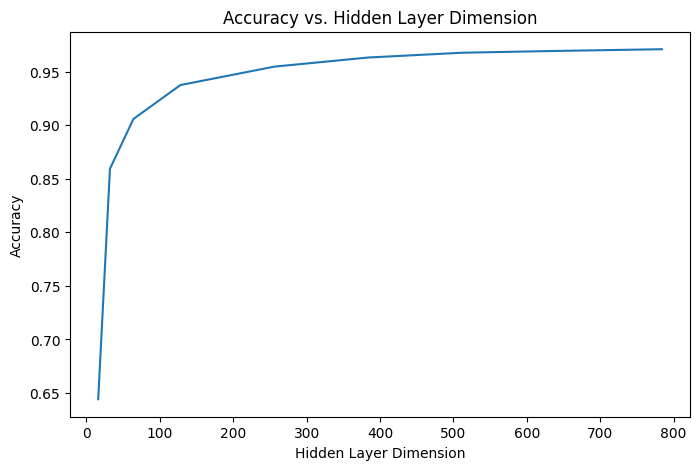

[16: 0.6442] [32: 0.8593] [64: 0.9058] [128: 0.9374] [256: 0.9546] [384: 0.9631] [512: 0.9676] [640: 0.9692] [784: 0.9708] 
Best parameters: {'log_reg__C': 0.5, 'log_reg__solver': 'sag', 'rbm__batch_size': 20, 'rbm__learning_rate': 0.05, 'rbm__n_components': 784}


In [58]:
X_train, X_test, y_train, y_test = utils.get_dataset(utils.Dataset_Select.MNIST.value, 10)
 
param_grid = {
    "rbm__n_components": [16, 32, 64, 128, 256, 384, 512, 640, 784],
    "rbm__learning_rate": [0.05],
    "rbm__batch_size": [20],
    "log_reg__C": [0.5],
    "log_reg__solver": ["sag"],
}

print("\n\n----- Odnajdowanie najlepszego RBM do klasyfikacji -----\n\n")
mnist_best_estimator = find_and_viz_best_estimator(X_train, y_train, 1000, param_grid)

In [59]:
print("\n\n----- Porównanie wyuczonego RBM z baseline-m -----\n\n")
log_reg = LogisticRegression(max_iter=1000, C=0.5, solver='sag')
compare_baseline_with_best_estimator(log_reg, mnist_best_estimator, X_train, y_train, X_test, y_test)



----- Porównanie wyuczonego RBM z baseline-m -----


--- Baseline: ---

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.93      0.93      0.93       982
           5       0.88      0.86      0.87       892
           6       0.94      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

--- Best Estimator: ---

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99



----- Wizualizacja wag RBM -----




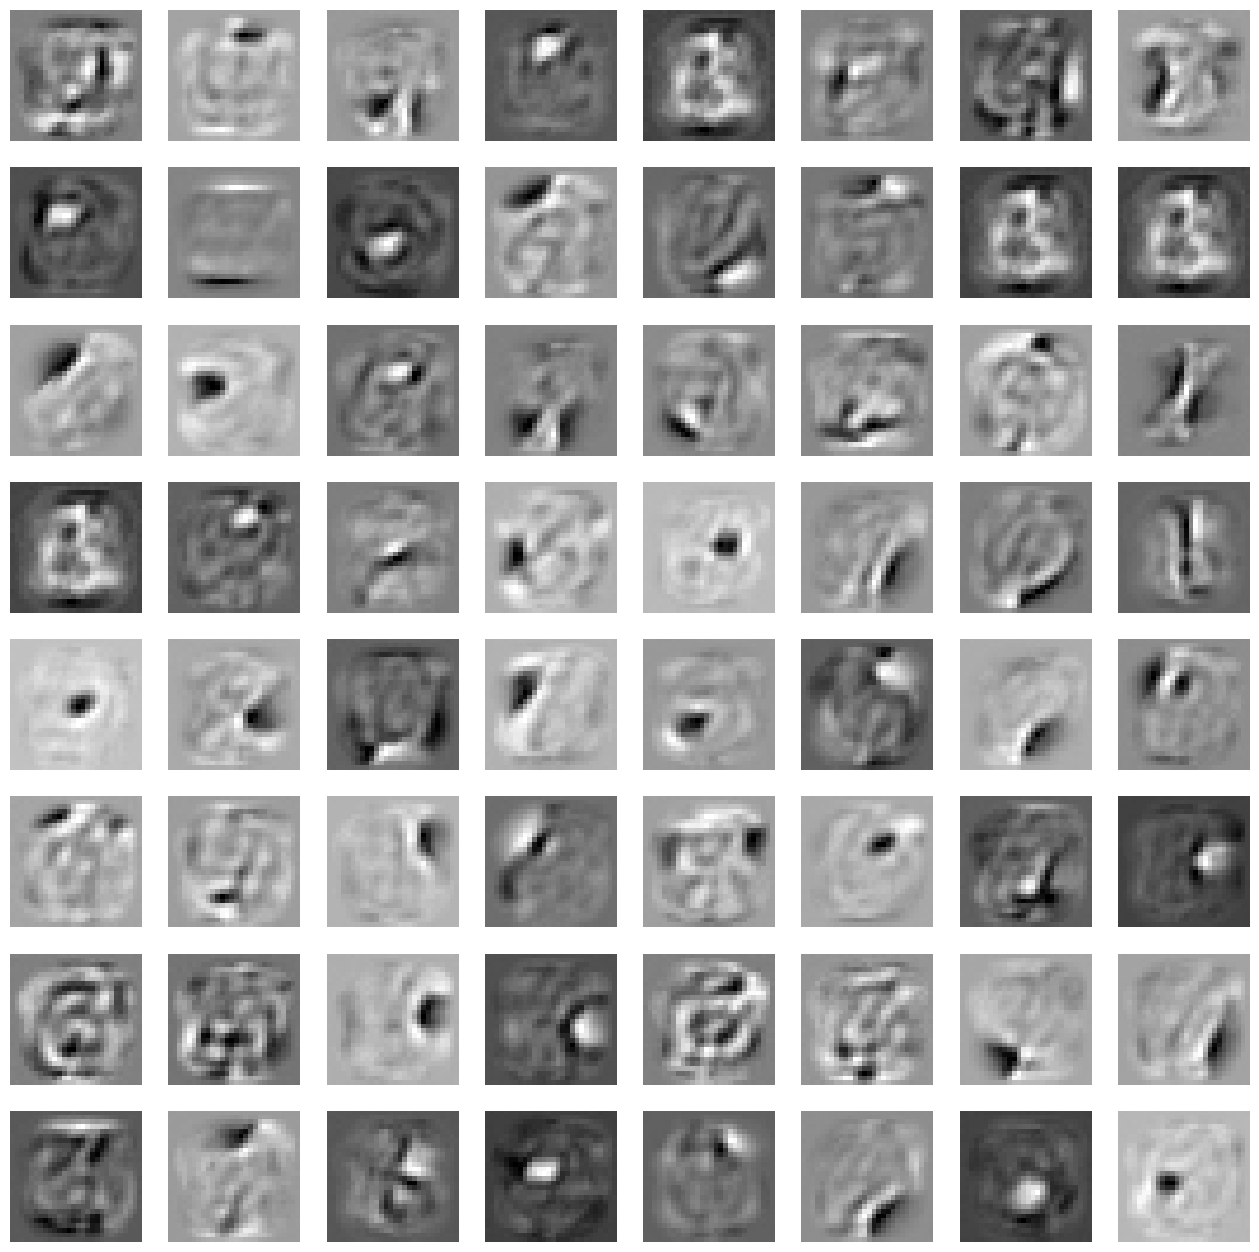

In [60]:
print("\n\n----- Wizualizacja wag RBM -----\n\n")
rbm = BernoulliRBM(n_components=64, learning_rate=0.05, batch_size=20, random_state=seed)
viz_weights(rbm, X_train, y_train)

### Fashion MNIST

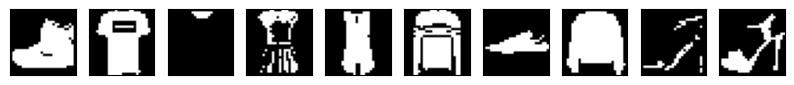



----- Odnajdowanie najlepszego RBM do klasyfikacji -----


Fitting 7 folds for each of 9 candidates, totalling 63 fits


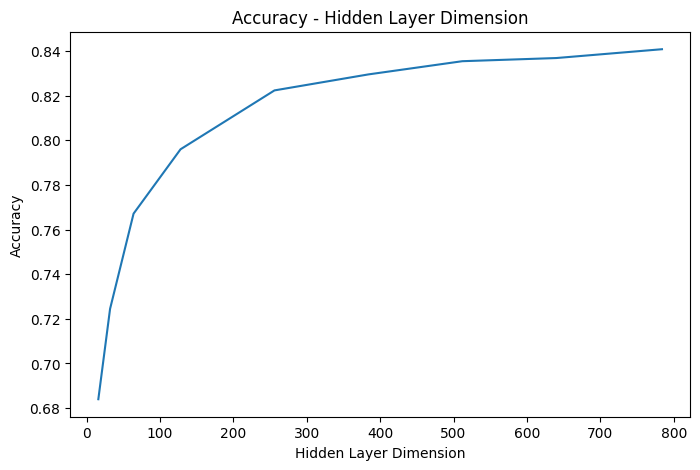

[16: 0.6840] [32: 0.7245] [64: 0.7671] [128: 0.7960] [256: 0.8223] [384: 0.8295] [512: 0.8354] [640: 0.8368] [784: 0.8408] 
Best parameters: {'log_reg__C': 0.5, 'log_reg__solver': 'sag', 'rbm__batch_size': 10, 'rbm__learning_rate': 0.01, 'rbm__n_components': 784}


In [7]:
X_train, X_test, y_train, y_test = utils.get_dataset(utils.Dataset_Select.F_MNIST.value, 10)

param_grid = {
    "rbm__n_components": [16, 32, 64, 128, 256, 384, 512, 640, 784],
    "rbm__learning_rate": [0.01],
    "rbm__batch_size": [10],
    "log_reg__C": [0.5],
    "log_reg__solver": ["sag"],
}

print("\n\n----- Odnajdowanie najlepszego RBM do klasyfikacji -----\n\n")
fashion_mnist_best_estimator = find_and_viz_best_estimator(X_train, y_train, 5000, param_grid)

In [8]:
print("\n\n----- Porównanie wyuczonego RBM z baseline-m -----\n\n")
log_reg = LogisticRegression(max_iter=5000, C=0.5, solver='sag')
compare_baseline_with_best_estimator(log_reg, fashion_mnist_best_estimator, X_train, y_train, X_test, y_test)



----- Porównanie wyuczonego RBM z baseline-m -----


--- Baseline: ---

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1000
           1       0.93      0.94      0.94      1000
           2       0.69      0.67      0.68      1000
           3       0.78      0.78      0.78      1000
           4       0.68      0.71      0.69      1000
           5       0.86      0.88      0.87      1000
           6       0.54      0.50      0.52      1000
           7       0.86      0.88      0.87      1000
           8       0.91      0.89      0.90      1000
           9       0.91      0.92      0.91      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

--- Best Estimator: ---

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1000
           1       0.97      0.96



----- Wizualizacja wag RBM -----




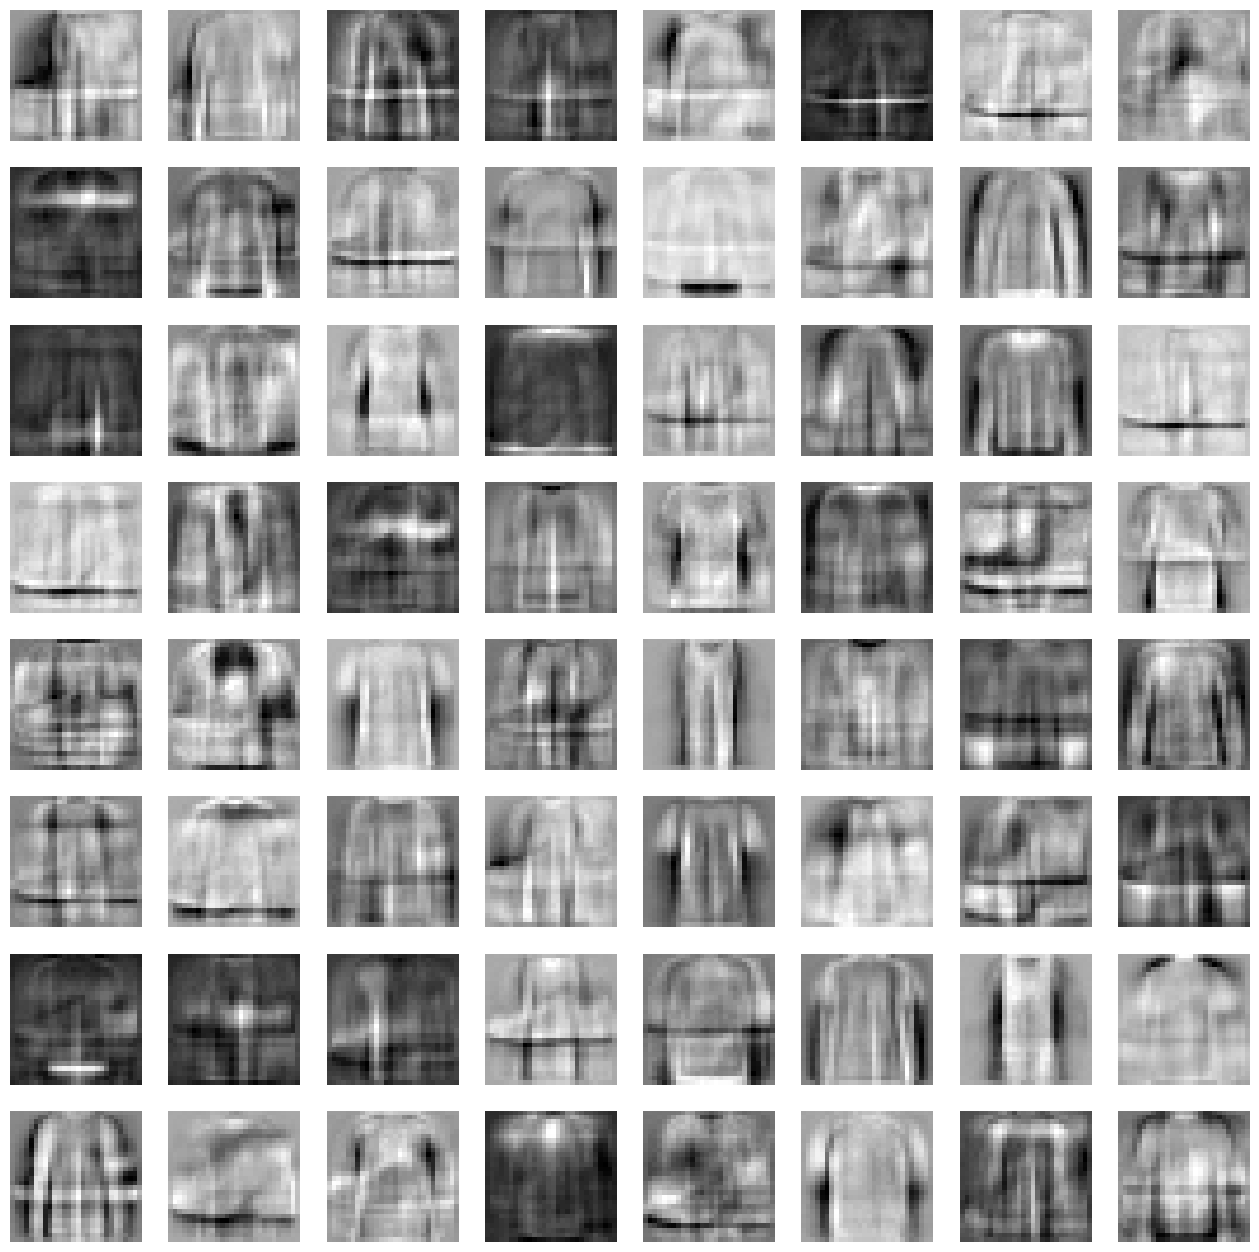

In [9]:
print("\n\n----- Wizualizacja wag RBM -----\n\n")
rbm = BernoulliRBM(n_components=64, learning_rate=0.01, batch_size=10, random_state=seed)
viz_weights(rbm, X_train, y_train)

```
    param_grid = {
        "rbm__n_components": [128, 256, 384],
        "rbm__learning_rate": [0.01, 0.05, 0.1],
        "rbm__batch_size": [10, 20],
        "log_reg__C": [0.1, 0.5, 1.0],
        "log_reg__solver": ["lbfgs", "sag"],
    }

Best parameters: {'log_reg__C': 0.5, 'log_reg__solver': 'sag', 'rbm__batch_size': 10, 'rbm__learning_rate': 0.01, 'rbm__n_components': 384}
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.71      0.71      1000
           3       0.83      0.84      0.83      1000
           4       0.70      0.74      0.72      1000
           5       0.90      0.89      0.89      1000
           6       0.60      0.55      0.57      1000
           7       0.90      0.90      0.90      1000
           8       0.92      0.94      0.93      1000
           9       0.92      0.93      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000
```

### Kuzushiji MNIST

2025-01-05 17:02:58.790991: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-05 17:03:03.296473: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-05 17:03:04.108536: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


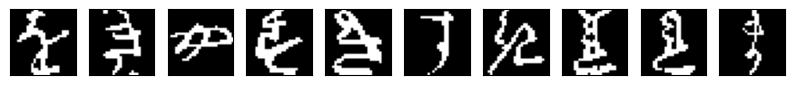



----- Odnajdowanie najlepszego RBM do klasyfikacji -----


Fitting 7 folds for each of 9 candidates, totalling 63 fits


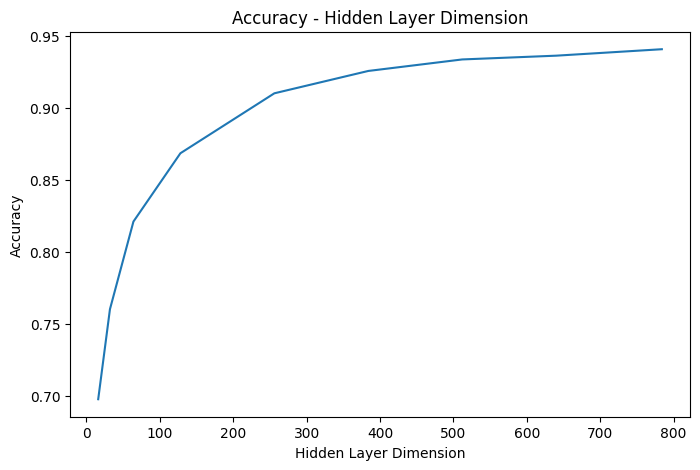

[16: 0.6975] [32: 0.7600] [64: 0.8210] [128: 0.8684] [256: 0.9101] [384: 0.9256] [512: 0.9336] [640: 0.9362] [784: 0.9407] 
Best parameters: {'log_reg__C': 1.0, 'log_reg__solver': 'sag', 'rbm__batch_size': 10, 'rbm__learning_rate': 0.1, 'rbm__n_components': 784}


In [10]:
X_train, X_test, y_train, y_test = utils.get_dataset(utils.Dataset_Select.K_MNIST.value, 10)

param_grid = {
    "rbm__n_components": [16, 32, 64, 128, 256, 384, 512, 640, 784],
    "rbm__learning_rate": [0.1],
    "rbm__batch_size": [10],
    "log_reg__C": [1.0],
    "log_reg__solver": ["sag"],
}

print("\n\n----- Odnajdowanie najlepszego RBM do klasyfikacji -----\n\n")
kuzushiji_mnist_best_estimator = find_and_viz_best_estimator(X_train, y_train, 1000, param_grid)

In [11]:
print("\n\n----- Porównanie wyuczonego RBM z baseline-m -----\n\n")
log_reg = LogisticRegression(max_iter=1000, C=1.0, solver='sag')
compare_baseline_with_best_estimator(log_reg, kuzushiji_mnist_best_estimator, X_train, y_train, X_test, y_test)



----- Porównanie wyuczonego RBM z baseline-m -----


--- Baseline: ---

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1000
           1       0.64      0.67      0.65      1000
           2       0.51      0.63      0.57      1000
           3       0.79      0.76      0.77      1000
           4       0.63      0.64      0.64      1000
           5       0.74      0.70      0.72      1000
           6       0.67      0.71      0.69      1000
           7       0.74      0.56      0.64      1000
           8       0.62      0.74      0.68      1000
           9       0.70      0.64      0.67      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000

--- Best Estimator: ---

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1000
           1       0.87      0.86



----- Wizualizacja wag RBM -----




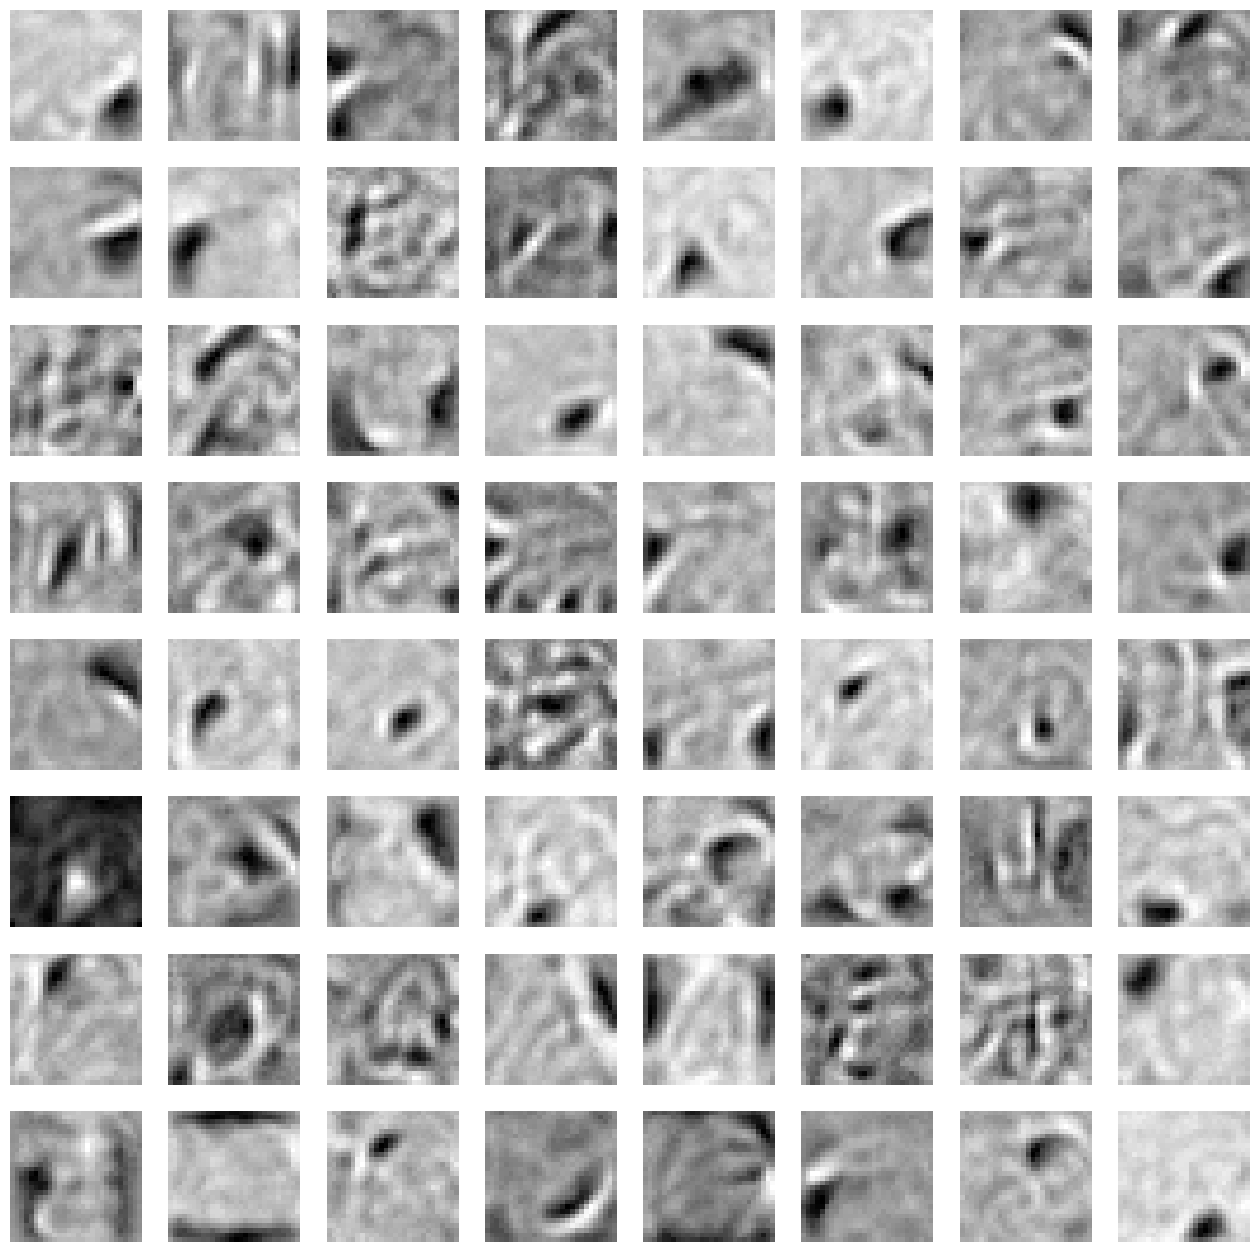

In [12]:
print("\n\n----- Wizualizacja wag RBM -----\n\n")
rbm = BernoulliRBM(n_components=64, learning_rate=0.1, batch_size=10, random_state=seed)
viz_weights(rbm, X_train, y_train)

```

    param_grid = {
        "rbm__n_components": [128, 256, 384],
        "rbm__learning_rate": [0.01, 0.05, 0.1],
        "rbm__batch_size": [10, 20],
        "log_reg__C": [0.1, 0.5, 1.0],
        "log_reg__solver": ["lbfgs", "sag"],
    }

Best parameters: {'log_reg__C': 1.0, 'log_reg__solver': 'sag', 'rbm__batch_size': 10, 'rbm__learning_rate': 0.1, 'rbm__n_components': 384}



              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1000
           1       0.85      0.83      0.84      1000
           2       0.76      0.78      0.77      1000
           3       0.87      0.91      0.89      1000
           4       0.82      0.81      0.82      1000
           5       0.92      0.82      0.86      1000
           6       0.76      0.88      0.82      1000
           7       0.88      0.83      0.85      1000
           8       0.83      0.88      0.85      1000
           9       0.90      0.86      0.88      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000
```

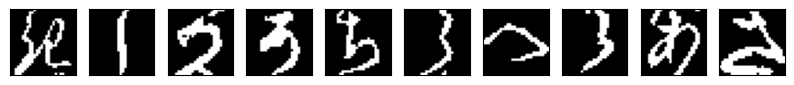

Fitting 7 folds for each of 9 candidates, totalling 63 fits
Best parameters: {'log_reg__C': 0.5, 'log_reg__solver': 'sag', 'rbm__batch_size': 20, 'rbm__learning_rate': 0.1, 'rbm__n_components': 512}
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       995
           1       0.94      0.94      0.94       962
          10       0.88      0.85      0.86      1052
          11       0.88      0.88      0.88       970
          12       0.77      0.79      0.78       960
          13       0.87      0.89      0.88       669
          14       0.82      0.81      0.81       629
          15       0.80      0.76      0.78      1012
          16       0.86      0.89      0.88       425
          17       0.84      0.84      0.84       953
          18       0.91      0.89      0.90       976
          19       0.84      0.84      0.84      1046
           2       0.86      0.90      0.88      1020
          20       0.79      0.79      0.79 

In [ ]:
X_train, X_test, y_train, y_test = utils.get_dataset(utils.Dataset_Select.KUZ_49.value, 10)

param_grid = {
    "rbm__n_components": [16, 32, 64, 128, 256, 384, 512, 640, 784],
    "rbm__learning_rate": [0.1],
    "rbm__batch_size": [20],
    "log_reg__C": [0.5],
    "log_reg__solver": ["sag"],
}

print("\n\n----- Odnajdowanie najlepszego RBM do klasyfikacji -----\n\n")
kuzushiji_49_best_estimator = find_and_viz_best_estimator(X_train, y_train, 1000, param_grid)

In [ ]:
print("\n\n----- Porównanie wyuczonego RBM z baseline-m -----\n\n")
log_reg = LogisticRegression(max_iter=1000, C=0.5, solver='sag')
compare_baseline_with_best_estimator(log_reg, kuzushiji_49_best_estimator, X_train, y_train, X_test, y_test)

In [ ]:
print("\n\n----- Wizualizacja wag RBM -----\n\n")
rbm = BernoulliRBM(n_components=64, learning_rate=0.1, batch_size=20, random_state=seed)
viz_weights(rbm, X_train, y_train)

```

    param_grid = {
        "rbm__n_components": [128, 256, 384],
        "rbm__learning_rate": [0.01, 0.05, 0.1],
        "rbm__batch_size": [10, 20],
        "log_reg__C": [0.1, 0.5, 1.0],
        "log_reg__solver": ["lbfgs", "sag"],
    }

Best parameters: {'log_reg__C': 0.5, 'log_reg__solver': 'sag', 'rbm__batch_size': 20, 'rbm__learning_rate': 0.1, 'rbm__n_components': 384}
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       995
           1       0.93      0.93      0.93       962
          10       0.87      0.84      0.85      1052
          11       0.85      0.85      0.85       970
          12       0.74      0.75      0.75       960
          13       0.88      0.88      0.88       669
          14       0.81      0.79      0.80       629
          15       0.78      0.73      0.75      1012
          16       0.85      0.88      0.87       425
          17       0.78      0.83      0.80       953
          18       0.87      0.88      0.88       976
          19       0.80      0.80      0.80      1046
           2       0.85      0.87      0.86      1020
          20       0.77      0.76      0.76      1066
          21       0.80      0.77      0.78       954
          22       0.82      0.80      0.81       321
          23       0.74      0.76      0.75       394
          24       0.83      0.82      0.82      1005
          25       0.86      0.80      0.83      1003
          26       0.91      0.92      0.91       861
          27       0.89      0.88      0.88       976
          28       0.96      0.95      0.95      1000
          29       0.70      0.64      0.67       284
           3       0.78      0.72      0.75       138
          30       0.71      0.78      0.75       975
          31       0.76      0.70      0.73       521
          32       0.86      0.82      0.84       308
          33       0.80      0.78      0.79       567
          34       0.80      0.78      0.79      1067
          35       0.85      0.92      0.88      1011
          36       0.78      0.81      0.79       251
          37       0.89      0.90      0.90      1006
          38       0.79      0.81      0.80      1052
          39       0.76      0.76      0.76      1013
           4       0.89      0.89      0.89       980
          40       0.70      0.71      0.71      1001
          41       0.79      0.85      0.82       981
          42       0.78      0.77      0.78       397
          43       0.81      0.75      0.78       416
          44       0.82      0.68      0.74        78
          45       0.74      0.70      0.72        60
          46       0.89      0.87      0.88      1020
          47       0.95      0.96      0.95      1004
          48       0.77      0.76      0.77       553
           5       0.71      0.65      0.68       990
           6       0.77      0.79      0.78      1071
           7       0.84      0.86      0.85       959
           8       0.69      0.70      0.70       754
           9       0.83      0.80      0.82       996

    accuracy                           0.82     38702
   macro avg       0.81      0.81      0.81     38702
weighted avg       0.82      0.82      0.82     38702

```